# Predicting GOOG Stocks

## Setup

In [22]:
import pandas as pd
import quandl as Quandl
import math
import datetime
import numpy as np
from sklearn import preprocessing, cross_validation, svm
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from matplotlib import style

style.use('ggplot')

This is the data we have available from Quandl

In [23]:
df = Quandl.get('WIKI/GOOGL')
print(df.head())

              Open    High     Low    Close      Volume  Ex-Dividend  \
Date                                                                   
2004-08-19  100.01  104.06   95.96  100.335  44659000.0          0.0   
2004-08-20  101.01  109.08  100.50  108.310  22834300.0          0.0   
2004-08-23  110.76  113.48  109.05  109.400  18256100.0          0.0   
2004-08-24  111.24  111.60  103.57  104.870  15247300.0          0.0   
2004-08-25  104.76  108.00  103.88  106.000   9188600.0          0.0   

            Split Ratio  Adj. Open  Adj. High   Adj. Low  Adj. Close  \
Date                                                                   
2004-08-19          1.0  50.159839  52.191109  48.128568   50.322842   
2004-08-20          1.0  50.661387  54.708881  50.405597   54.322689   
2004-08-23          1.0  55.551482  56.915693  54.693835   54.869377   
2004-08-24          1.0  55.792225  55.972783  51.945350   52.597363   
2004-08-25          1.0  52.542193  54.167209  52.100830   53.1

## Label and Features

In [24]:
df = df[['Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Close', 'Adj. Volume']]
df['High To Low Percentage'] = (
    df['Adj. High'] - df['Adj. Close']) / df['Adj. Close'] * 100
df['Change Percentage'] = (
    df['Adj. Close'] - df['Adj. Open']) / df['Adj. Open'] * 100

df = df[[
    'Adj. Close', 'High To Low Percentage', 'Change Percentage', 'Adj. Volume'
]]

forecast_col = 'Adj. Close'

# defines that the label is based of 10% of previous Adj. Close prices
forecast_range = int(math.ceil(0.01 * len(df)))
df['label'] = df[forecast_col].shift(-forecast_range)

# X is features, everything but label
X = np.array(df.drop(['label'], 1))
X = preprocessing.scale(X)
# Features for the last n days (like 33 days)
X_lately = X[-forecast_range:]
# All features but the latest n days (like 33 days)
X = X[:-forecast_range]
# drop NaNs or else we get an error while trying to run it through the classification algorithm, they will exist because of the previous shift
df.dropna(inplace=True)
y = np.array(df['label'])

print("X (features, what we use for prediction)", X);
print("y (label, what we want to predict)", forecast_col, y);

X (features, what we use for prediction) [[-1.49011972  2.30541104  0.23008832  4.37873288]
 [-1.47178708 -0.32078062  4.77150696  1.7613911 ]
 [-1.46928143  2.32017124 -0.79165762  1.2123474 ]
 ..., 
 [ 2.75994809 -0.8975846   0.1748138  -0.84164594]
 [ 2.82526062 -0.59699709  0.88058113 -0.74300444]
 [ 2.83172312 -0.6679557   0.10050314 -0.78241141]]
y (label, what we want to predict) Adj. Close [  68.75223155   69.63997192   69.0782379  ...,  967.66        968.7175
  976.91      ]


## Prediction

In [25]:
# split data for be used later for training and testing
X_train, X_test, y_train, y_test = cross_validation.train_test_split(
    X, y, test_size=0.2)

# end setup, now to the prediction!

classifier = LinearRegression()
# train
classifier.fit(X_train, y_train)
# test
accuracy = classifier.score(X_test, y_test)
# predict
forecast_result = classifier.predict(X_lately)

print("GOOG prices for the next", forecast_range, "days")
print(forecast_result)
print("Accuracy", accuracy)

GOOG prices for the next 33 days
[ 1012.40617448  1002.22688658  1004.43866438  1012.18532241  1019.69830475
  1011.86852674  1017.8318253   1020.78559076   982.29673169   976.09772976
   985.76633331   983.04203989   975.44473594   974.54320298   990.77017296
   984.09187661   994.62818165   992.82786789  1001.94903196   986.19427873
   961.85213637   975.97787797   952.18856834   944.15033809   934.10055067
   947.14740317   942.20025931   955.80801891   966.50326134   969.63062472
   983.39202342   983.73568362   993.41260234]
Accuracy 0.973305088044


## Graphics

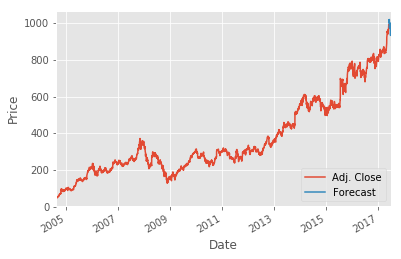

In [26]:
df['Forecast'] = np.nan

last_date = df.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day

for i in forecast_result:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += one_day
    df.loc[next_date] = [np.nan for _ in range(len(df.columns) - 1)] + [i]

df['Adj. Close'].plot()
df['Forecast'].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()